In [1]:
# Visualizes the location visit durations across different demographic (e.g., emplotyment) and mental health (e.g. depression)
# groups

import pickle
import os
import numpy as np
import pandas as pd

# reading top locations
with open('top_locations.dat') as f:
    location_top = pickle.load(f)
f.close()

# reading assessments
with open('../Assessment/assessment.dat') as f:
    data = pickle.load(f)
f.close()

# reading demographics
with open('../Demographics/demo.dat') as f:
    demo = pickle.load(f)
f.close()

# adding demo to dataframe
data.insert(loc=len(data.columns), column='gender', value=np.nan)
data.insert(loc=len(data.columns), column='age', value=np.nan)
data.insert(loc=len(data.columns), column='employment', value=np.nan)

for (i,subj) in enumerate(data['ID']):
    ind = np.where(demo['ID']==subj)[0][0]
    data.loc[i,'gender'] = demo.loc[ind, 'gender']
    data.loc[i,'age'] = demo.loc[ind, 'age']
    data.loc[i,'employment'] = demo.loc[ind, 'employment']

# adding durations to dataframes
for loc_top in location_top:
    data.insert(loc=len(data.columns), column=loc_top, value=np.nan)

folders = os.listdir('data/')
for fol in folders:
    ind_subject = np.where(data['ID']==fol)[0][0]
    subfolders = os.listdir('data/'+fol)
    data.loc[ind_subject, location_top] = 0
    dur_all = 0
    for subf in subfolders:
        file_eml = 'data/'+fol+'/'+subf+'/eml.csv'
        file_fus = 'data/'+fol+'/'+subf+'/fus.csv'
        if os.path.exists(file_eml) and os.path.exists(file_fus):
            df = pd.read_csv(file_eml, sep='\t', header=None)
            loc = df.loc[0,6][2:-2]
            df = pd.read_csv(file_fus, sep='\t', header=None)
            t = np.array(df.loc[:,0])
            tdiff = t[1:]-t[:-1]
            tdiff = tdiff[tdiff<600]
            dur = np.sum(tdiff)

            if loc in location_top:
                data.loc[ind_subject, loc] += dur
            dur_all += dur
    data.loc[ind_subject, location_top] /= dur_all #normalize


In [2]:
def remove_parentheses(ss):
    ss = np.array(ss)
    for i in range(ss.size):
        s = ss[i].split('(')
        s = s[0]
        ss[i] = s
    return ss

<IPython.core.display.Javascript object>


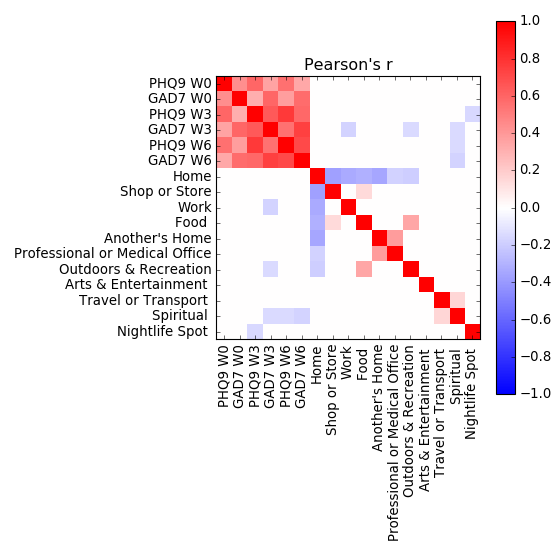

In [4]:
# correlation matrix

from soplata import *
from utils import *

data_new = data.drop(['ID','SPIN W0','SPIN W3','SPIN W6','gender','employment','age'],axis=1)
data_cov, pval = calculate_covariance(data_new.values.astype(float))

#%matplotlib inline
%matplotlib notebook

# truncate labels
# labs = [lab[0:20] for lab in data_new.columns]
labs = remove_parentheses(data_new.columns)

data_cov[pval>=0.05]=0

plot_confusion_matrix(data_cov, labels=labs, cmap=plt.cm.bwr, xsize=7, ysize=7, title='Pearson\'s r')


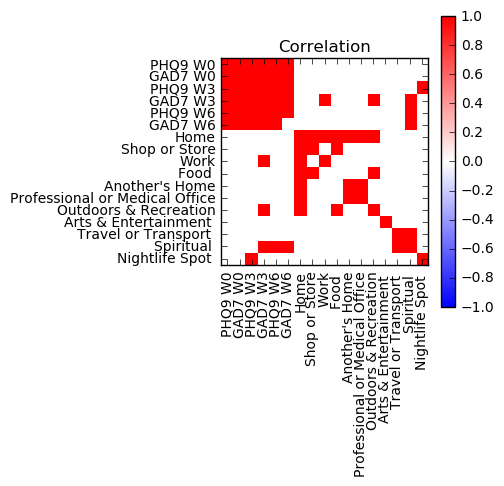

In [26]:
plot_confusion_matrix(pval<0.05, labels=labs, cmap=plt.cm.bwr, xsize=5, ysize=5)

In [9]:
# only mental health vars vs semantic locaiton

from scipy.stats import pearsonr, spearmanr

target = data_new[['PHQ9 W0','PHQ9 W3','PHQ9 W6','GAD7 W0','GAD7 W3','GAD7 W6']]
location = data_new.drop(['PHQ9 W0','PHQ9 W3','PHQ9 W6','GAD7 W0','GAD7 W3','GAD7 W6'],axis=1)

r = pd.DataFrame(index=location.columns, columns=target.columns)
p = pd.DataFrame(index=location.columns, columns=target.columns)
tab = pd.DataFrame(index=location.columns, columns=target.columns, dtype=str)
for tar in target.columns:
    for loc in location.columns:
        x = target.loc[:,tar].astype(float)
        y = location.loc[:,loc].astype(float)
        indnan = np.where(np.logical_or(np.isnan(x),np.isnan(y)))[0]
        x = x.drop(indnan)
        y = y.drop(indnan)
        x = x.reset_index(drop=True)
        y = y.reset_index(drop=True)
        rr,pp = pearsonr(x,y)
        r.loc[loc,tar] = rr
        p.loc[loc,tar] = pp


In [32]:
# only mental health vars vs semantic locaiton - with bootstrap

from scipy.stats import pearsonr, spearmanr

n_bs = 1000

corr_med = pd.DataFrame(index=location.columns, columns=target.columns)
corr_hi = pd.DataFrame(index=location.columns, columns=target.columns)
corr_lo = pd.DataFrame(index=location.columns, columns=target.columns)
for tar in target.columns:
    for loc in location.columns:
        x = target.loc[:,tar].astype(float)
        y = location.loc[:,loc].astype(float)
        indnan = np.where(np.logical_or(np.isnan(x),np.isnan(y)))[0]
        x = x.drop(indnan)
        y = y.drop(indnan)
        x = x.reset_index(drop=True)
        y = y.reset_index(drop=True)
        r = np.zeros([n_bs])
        p = np.zeros([n_bs])
        for bs in range(n_bs):
            ind = np.random.choice(np.arange(x.size), size=x.size, replace=True)
            x_s = x.loc[ind]
            y_s = y.loc[ind]
            r[bs],p[bs] = pearsonr(x_s,y_s)
        corr_med.loc[loc,tar] = np.median(r)
        corr_hi.loc[loc,tar] = np.percentile(r, 99.9)
        corr_lo.loc[loc,tar] = np.percentile(r, 0.1)

(array([   4.,    2.,    7.,   23.,   31.,   52.,   75.,   81.,  103.,
         105.,  110.,   87.,   87.,   67.,   44.,   26.,   31.,   24.,
          15.,   12.,    5.,    5.,    3.,    0.,    1.]),
 array([-0.26589565, -0.24293962, -0.21998358, -0.19702754, -0.1740715 ,
        -0.15111546, -0.12815942, -0.10520339, -0.08224735, -0.05929131,
        -0.03633527, -0.01337923,  0.00957681,  0.03253285,  0.05548888,
         0.07844492,  0.10140096,  0.124357  ,  0.14731304,  0.17026908,
         0.19322511,  0.21618115,  0.23913719,  0.26209323,  0.28504927,
         0.30800531]),
 <a list of 25 Patch objects>)

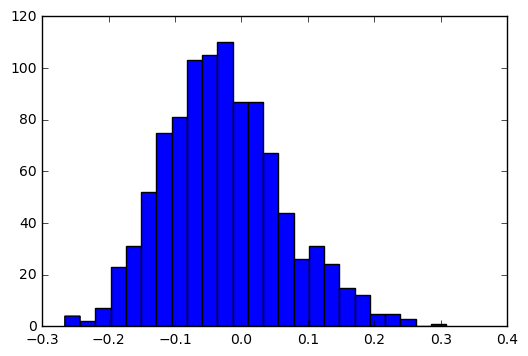

In [24]:
%matplotlib inline
plt.hist(r,25)

In [11]:
# print the table
corr_med

,PHQ9 W0,PHQ9 W3,PHQ9 W6,GAD7 W0,GAD7 W3,GAD7 W6
Home,0.0550334,0.0678761,0.0861458,0.0845286,0.10097,0.10087
Shop or Store,-0.0114585,0.0161893,-0.0171673,0.00366271,-0.0346854,-0.0327031
Work,-0.084718,-0.138576,-0.143176,-0.0777867,-0.175179,-0.0893758
"Food (Restaurant, Cafe)",-0.0294034,-0.0707818,-0.13099,-0.0241145,-0.107236,-0.0873549
Another's Home,0.0426744,-0.0671273,-0.0689995,-0.0172823,-0.00635979,0.000748315
Professional or Medical Office,0.0338988,0.101643,0.0496354,-0.0728649,0.0187777,0.0527637
Outdoors & Recreation,0.014826,-0.122995,-0.100875,-0.0675285,-0.131181,-0.111387
"Arts & Entertainment (Theater, Music Venue, Etc.)",-0.126404,-0.053075,-0.0382284,0.0326158,0.0248179,-0.0193428
"Travel or Transport (Airport, Bus Stop, Train Station, Etc.)",-0.0648969,-0.0325081,-0.113947,0.0854335,0.00367957,-0.0892303
"Spiritual (Church, Temple, Etc.)",-0.0399473,-0.0807502,-0.14515,-0.092222,-0.141653,-0.16724


In [33]:
np.sign(corr_lo)+np.sign(corr_hi)

,PHQ9 W0,PHQ9 W3,PHQ9 W6,GAD7 W0,GAD7 W3,GAD7 W6
Home,0,0,0,0,0,0
Shop or Store,0,0,0,0,0,0
Work,0,0,0,0,0,0
"Food (Restaurant, Cafe)",0,0,0,0,0,0
Another's Home,0,0,0,0,0,0
Professional or Medical Office,0,0,0,0,0,0
Outdoors & Recreation,0,0,0,0,0,0
"Arts & Entertainment (Theater, Music Venue, Etc.)",0,0,0,0,0,0
"Travel or Transport (Airport, Bus Stop, Train Station, Etc.)",0,0,0,0,0,0
"Spiritual (Church, Temple, Etc.)",0,0,0,0,0,0


In [18]:
np.max(corr_hi, keepdims=False)

PHQ9 W0    0.226642
PHQ9 W3    0.300850
PHQ9 W6    0.282217
GAD7 W0    0.233019
GAD7 W3    0.228345
GAD7 W6    0.235018
dtype: float64

In [19]:
np.min(corr_lo, keepdims=False)

PHQ9 W0   -0.237318
PHQ9 W3   -0.299829
PHQ9 W6   -0.272490
GAD7 W0   -0.206892
GAD7 W3   -0.308565
GAD7 W6   -0.253944
dtype: float64

In [35]:
.05/66

0.0007575757575757576